In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import math
import pickle
from datetime import datetime, timedelta

from imblearn.over_sampling import SMOTE
from collections import Counter

## Loading Cleaned Datasets

Our datasets were cleaned in separate Jupyter notebooks.

In [2]:
##### EPIDEMIC dataset #####
## Cases and Testing
cases_malaysia = pickle.load(open('pickle_files/cases_malaysia.pkl', 'rb'))
cases_malaysia_cluster = pickle.load(open('pickle_files/cases_malaysia_cluster.pkl', 'rb'))
cases_state = pickle.load(open('pickle_files/cases_state.pkl', 'rb')) 

tests_malaysia = pickle.load(open('pickle_files/tests_malaysia.pkl', 'rb')) 
tests_state = pickle.load(open('pickle_files/tests_state.pkl', 'rb')) 

## Deaths
deaths_malaysia = pickle.load(open('pickle_files/deaths_malaysia.pkl', 'rb'))
deaths_state = pickle.load(open('pickle_files/deaths_state.pkl', 'rb')) 

## Static Data
population = pd.read_csv('dataset/static/population_moh.csv')

##### VACCINATION & REGISTRATION dataset #####
## Adverse Events Following Immunization (AEFI)
aefi = pickle.load(open('pickle_files/aefi.pkl', 'rb'))
aefi_serious = pickle.load(open('pickle_files/aefi_serious.pkl', 'rb'))

## Vaccination
vax_malaysia = pickle.load(open('pickle_files/vax_malaysia.pkl', 'rb'))
vax_state = pickle.load(open('pickle_files/vax_state.pkl', 'rb'))

## Registration
vaxreg_malaysia = pickle.load(open('pickle_files/vaxreg_malaysia.pkl', 'rb'))
vaxreg_state = pickle.load(open('pickle_files/vaxreg_state.pkl', 'rb'))

##### MYSEJAHTERA dataset #####
checkin_malaysia = pickle.load(open('pickle_files/checkin_malaysia.pkl', 'rb'))
checkin_malaysia_time = pickle.load(open('pickle_files/checkin_malaysia_time.pkl', 'rb'))
checkin_state = pickle.load(open('pickle_files/checkin_state.pkl', 'rb'))
trace_malaysia = pickle.load(open('pickle_files/trace_malaysia.pkl', 'rb'))

## Exploratory Data Analysis

### EDA 1: Analyse which group of population are more vulnerable to covid cases based on cases type in Malaysia.

#### 1.1 cases_malaysia

In [3]:
cases_malaysia.tail(3)

,date,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_pvax,cases_fvax,cases_child,cases_adolescent,cases_adult,cases_elderly
617,2021-10-03,9066,12,14454,150146,388,1119,4941,1700,764,5348,1087
618,2021-10-04,8075,6,15456,142746,731,1093,4282,1353,641,5050,948
619,2021-10-05,8817,14,15615,135945,619,1060,5105,1386,686,5624,1007


In [4]:
cases_type = ['cases_new',\
              'cases_import',\
              'cases_recovered',\
              'cases_cluster',\
              'cases_pvax','cases_fvax',\
              'cases_child','cases_adolescent','cases_adult','cases_elderly']
cases_malaysia_melt = cases_malaysia[cases_type].melt()
cases_malaysia_melt.columns = ['cases_type', 'count'] # change column name
cases_malaysia_melt

,cases_type,count
0,cases_new,4
1,cases_new,0
2,cases_new,0
3,cases_new,0
4,cases_new,3
...,...,...
6195,cases_elderly,1277
6196,cases_elderly,1166
6197,cases_elderly,1087
6198,cases_elderly,948


In [5]:
# sns.set(rc={'figure.figsize':(11,6)})
# sns.set(style="whitegrid", color_codes=True)

# plot_cases_type = sns.swarmplot(x='cases_Type', y='count', data=cases_malaysia_melt)

# plot_cases_type.set_xticklabels(plot_cases_type.get_xticklabels(), rotation=90)
# plot_cases_type.set_title('Cases Type and Count')
# plot_cases_type.set_ylabel('Cases Type')
# plot_cases_type.set_xlabel('Count')

In [6]:
df_casesTotal = cases_malaysia_melt.groupby(["cases_type"]).sum() 
df_casesTotal.reset_index(inplace=True)
df_casesTotal

,cases_type,count
0,cases_adolescent,158432
1,cases_adult,1577927
2,cases_child,304128
3,cases_cluster,473962
4,cases_elderly,182713
5,cases_fvax,343027
6,cases_import,4915
7,cases_new,2294457
8,cases_pvax,373610
9,cases_recovered,2131636


In [7]:
def findCasesByOption(df_casesTotal, options):
    df_optionTotal = df_casesTotal.loc[df_casesTotal['cases_type'].isin(options)]
    df_optionTotal.sort_values('count', axis=0, inplace=True)
    return df_optionTotal

In [8]:
def plotCasesByOption(df_casesTotal, title='', x_label='', y_label='Number of Cases', ymax=2000000):
    sns.set(rc={'figure.figsize':(11,6)})
    sns.set(style="whitegrid", color_codes=True)

    b = sns.barplot(x="cases_type", y="count",  data=df_casesTotal)
    b.set_xticklabels(b.get_xticklabels(), rotation=90)
    b.set_title(title)
    b.set_ylabel(x_label)
    b.set_xlabel(y_label)
    b.set(ylim=(0, ymax))

    for p in b.patches:
            b.annotate("%.0f" % p.get_height(), (p.get_x() + 
        p.get_width() / 2., p.get_height()), 
            ha='center', va='center', rotation=0, 
        xytext=(0, 18), textcoords='offset points')

In [9]:
options = ['cases_child','cases_adolescent','cases_adult','cases_elderly']
df_casesAgeTotal = findCasesByOption(df_casesTotal, options)
df_casesAgeTotal

<ipython-input-7-e3fdf8520685>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_optionTotal.sort_values('count', axis=0, inplace=True)


,cases_type,count
0,cases_adolescent,158432
4,cases_elderly,182713
2,cases_child,304128
1,cases_adult,1577927


In [10]:
ageVerifiedTotal = df_casesAgeTotal['count'].sum()
casesTotal = df_casesTotal[df_casesTotal['cases_type'] == 'cases_new']['count'].sum()
ageUnVerifiedTotal = casesTotal - ageVerifiedTotal
ageUnVerifiedTotal

71257

In [11]:
ageUnVerifiedDict = {'cases_type': 'cases_unverified_age', 'count': ageUnVerifiedTotal}
df_casesAgeTotal = df_casesAgeTotal.append(ageUnVerifiedDict, ignore_index = True,)
df_casesAgeTotal.sort_values('count', axis=0, inplace=True)
df_casesAgeTotal

,cases_type,count
4,cases_unverified_age,71257
0,cases_adolescent,158432
1,cases_elderly,182713
2,cases_child,304128
3,cases_adult,1577927


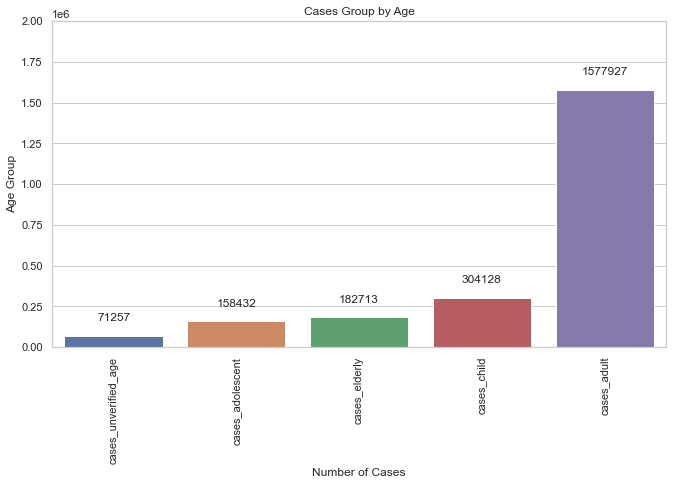

In [12]:
plotCasesByOption(df_casesAgeTotal, 'Cases Group by Age', 'Age Group', 'Number of Cases')

One key observation is that cases_child has more than 100k than other age limit accept cases_adult. The reason is unknown but we deduce that if the adult get covid cases, there's high chance that the child have to depends on adults

In [13]:
options = ['cases_pvax','cases_fvax']
df_casesGroupByVaccine = findCasesByOption(df_casesTotal, options)
df_casesGroupByVaccine

<ipython-input-7-e3fdf8520685>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_optionTotal.sort_values('count', axis=0, inplace=True)


,cases_type,count
5,cases_fvax,343027
8,cases_pvax,373610


In [14]:
casesVaccinedTotal = df_casesGroupByVaccine['count'].sum()
casesTotal = df_casesTotal[df_casesTotal['cases_type'] == 'cases_new']['count'].sum()
casesUnvaccinatedTotal = casesTotal - casesVaccinedTotal
casesUnvaccinatedTotal

1577820

In [15]:
casesUnvaccinatedDict = {'cases_type': 'cases_unvaccinated', 'count': casesUnvaccinatedTotal}
df_casesGroupByVaccine = df_casesGroupByVaccine.append(casesUnvaccinatedDict, ignore_index = True,)
df_casesGroupByVaccine.sort_values('count', axis=0, inplace=True)
df_casesGroupByVaccine

,cases_type,count
0,cases_fvax,343027
1,cases_pvax,373610
2,cases_unvaccinated,1577820


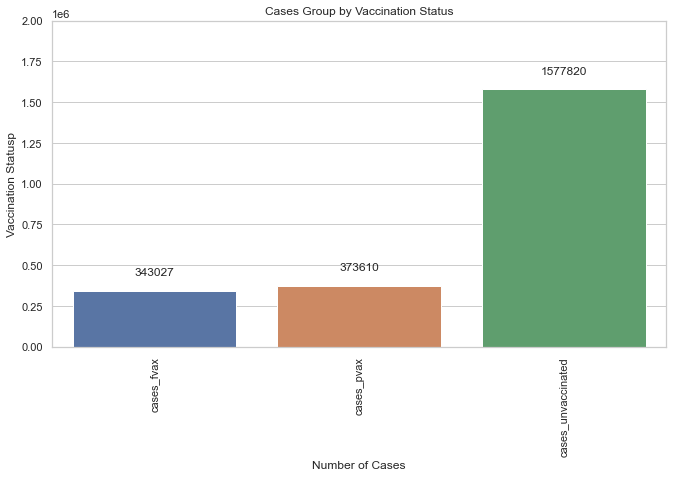

In [16]:
plotCasesByOption(df_casesGroupByVaccine, 'Cases Group by Vaccination Status', 'Vaccination Statusp')

#### 1.2 cases_malaysia_cluster

In [17]:
cases_malaysia_cluster.head(3)

,date,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_pvax,cases_fvax,cases_child,cases_adolescent,cases_adult,cases_elderly,cluster_import,cluster_religious,cluster_community,cluster_highRisk,cluster_education,cluster_detentionCentre,cluster_workplace
342,2021-01-01,2068,2,2230,23382,944,0,0,121,76,1721,119,0.0,0.0,35.0,17.0,0.0,18.0,671.0
343,2021-01-02,2295,9,3321,22347,1091,0,0,116,61,1896,117,0.0,2.0,30.0,33.0,0.0,135.0,882.0
344,2021-01-03,1704,5,2726,21317,588,0,0,160,77,1307,118,0.0,0.0,41.0,25.0,0.0,83.0,432.0


In [18]:
cases_type2 = ['cases_new',\
              'cluster_import',\
              'cluster_religious',\
              'cluster_community',\
              'cluster_highRisk',\
              'cluster_education',\
              'cluster_detentionCentre',\
              'cluster_workplace']
cases_malaysia_cluster_melt = cases_malaysia_cluster[cases_type2].melt()
cases_malaysia_cluster_melt.columns = ['cases_type', 'count'] # change column name
cases_malaysia_cluster_melt

,cases_type,count
0,cases_new,2068.0
1,cases_new,2295.0
2,cases_new,1704.0
3,cases_new,1741.0
4,cases_new,2027.0
...,...,...
2219,cluster_workplace,393.0
2220,cluster_workplace,380.0
2221,cluster_workplace,140.0
2222,cluster_workplace,613.0


In [19]:
df_casesClusterTotal = cases_malaysia_cluster_melt.groupby(["cases_type"]).sum() 
df_casesClusterTotal.sort_values('count', axis=0, inplace=True)
df_casesClusterTotal.reset_index(inplace=True)
df_casesClusterTotal

,cases_type,count
0,cluster_import,131.0
1,cluster_religious,8194.0
2,cluster_highRisk,8494.0
3,cluster_education,10851.0
4,cluster_detentionCentre,21832.0
5,cluster_community,69732.0
6,cluster_workplace,219381.0
7,cases_new,2181447.0


In [20]:
def getUncategorized(df, overall_column='', new_column_name=''):
    partial_sum = df[df['cases_type'] != overall_column]['count'].sum()
    overall_sum = df[df['cases_type'] == overall_column]['count'].sum()
    uncategorized_subset = overall_sum - partial_sum

    tempDict = {'cases_type': new_column_name, 'count': uncategorized_subset}
    df = df.append(tempDict, ignore_index = True,)
    df.sort_values('count', axis=0, inplace=True)
    return df

In [21]:
clusterTotal = getUncategorized(df_casesClusterTotal, 'cases_new', 'cluster_not_found')
clusterTotal = clusterTotal[clusterTotal['cases_type'] != 'cases_new']
clusterTotal

,cases_type,count
0,cluster_import,131.0
1,cluster_religious,8194.0
2,cluster_highRisk,8494.0
3,cluster_education,10851.0
4,cluster_detentionCentre,21832.0
5,cluster_community,69732.0
6,cluster_workplace,219381.0
8,cluster_not_found,1842832.0


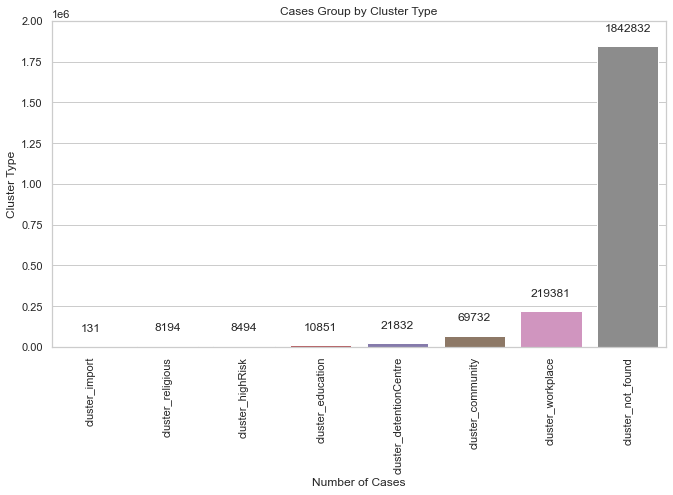

In [22]:
plotCasesByOption(clusterTotal, 'Cases Group by Cluster Type', 'Cluster Type', 'Number of Cases', 2000000)

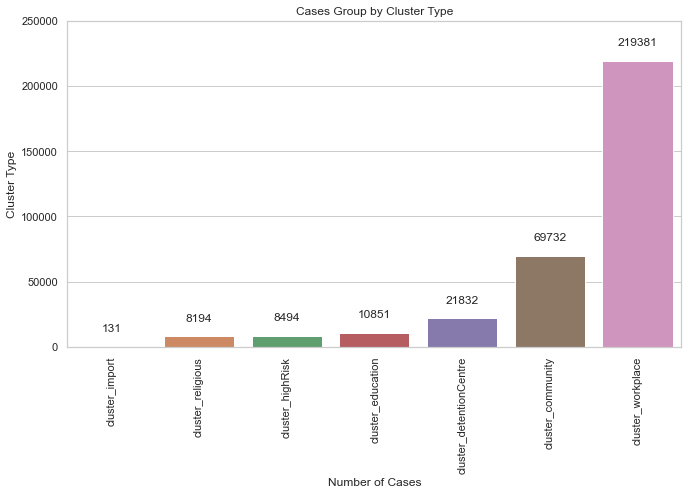

In [23]:
clusterTotal = clusterTotal[clusterTotal['cases_type'] != 'cluster_not_found']
plotCasesByOption(clusterTotal, 'Cases Group by Cluster Type', 'Cluster Type', 'Number of Cases', 250000)

In [24]:
options = ['cases_new','cases_import']
df_casesImportTotal = findCasesByOption(df_casesTotal, options)
df_casesImportTotal

<ipython-input-7-e3fdf8520685>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_optionTotal.sort_values('count', axis=0, inplace=True)


,cases_type,count
6,cases_import,4915
7,cases_new,2294457


#### 1.3 cases_state

In [25]:
cases_state.head(3)

,date,state,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_pvax,cases_fvax,cases_child,cases_adolescent,cases_adult,cases_elderly
0,2020-01-25,Johor,4,4,0,4,0,0,0,0,0,1,0
1,2020-01-25,Kedah,0,0,0,0,0,0,0,0,0,0,0
2,2020-01-25,Kelantan,0,0,0,0,0,0,0,0,0,0,0


In [26]:
tests_state.head(3)

,date,state,rtk-ag,pcr
0,2021-07-01,Johor,2749,3670
1,2021-07-01,Kedah,2073,1297
2,2021-07-01,Kelantan,1348,1966


In [27]:
deaths_state.head(3)

,date,state,deaths_new,deaths_bid,deaths_new_dod,deaths_bid_dod,deaths_pvax,deaths_fvax,deaths_tat
0,2020-03-17,Johor,1,0,1,0,0,0,0
1,2020-03-17,Kedah,0,0,0,0,0,0,0
2,2020-03-17,Kelantan,0,0,0,0,0,0,0


In [28]:
checkin_state.head(3)

,date,state,checkins,unique_ind,unique_loc
0,2020-12-01,Johor,1996696,868521,81635
1,2020-12-01,Kedah,654634,341620,32760
2,2020-12-01,Kelantan,186507,108035,16298


### EDA 2: Analyse how COVID cases vary across time dimension.

In [29]:
import datetime 

# Year, full version
def strftime_year(date):
    return date.strftime("%Y")

# Month as a number 01-12
def strftime_monthNumber(date):
    return date.strftime("%m")

# Week number of year, Sunday as the first day of week, 00-53
def strftime_weekNumber(date):
    return date.strftime("%W")

# Day number of year 001-366
def strftime_dayNumber(date):
    return date.strftime("%j")

#Weekday as a number 0-6, 0 is Sunday
def strftime_weekdayNumber(date):
    return date.strftime("%w")

# Weekday, full version
def strftime_weekdayName(date):
    return date.strftime("%A")

# shortcut for strftime a dataframe
def strftime_all(df):
    df_dt = df.copy()
    df_dt['year'] = df['date'].apply(strftime_year)
    df_dt['month_number'] = df_dt['date'].apply(strftime_monthNumber)
    df_dt['week_number'] = df_dt['date'].apply(strftime_weekNumber)
    df_dt['day_number'] = df_dt['date'].apply(strftime_dayNumber)
    df_dt['weekday_number'] = df_dt['date'].apply(strftime_weekdayNumber)
    df_dt['weekday_name'] = df_dt['date'].apply(strftime_weekdayName)
    return df_dt

In [30]:
df_cases_dateDim = cases_malaysia.copy()
df_cases_dateDim['date'] = df_cases_dateDim['date'].astype('datetime64[ns]')
df_cases_dateDim = strftime_all(df_cases_dateDim)
df_cases_dateDim

,date,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_pvax,cases_fvax,cases_child,cases_adolescent,cases_adult,cases_elderly,year,month_number,week_number,day_number,weekday_number,weekday_name
0,2020-01-25,4,4,0,4,0,0,0,0,0,1,0,2020,01,03,025,6,Saturday
1,2020-01-26,0,0,0,4,0,0,0,0,0,0,0,2020,01,03,026,0,Sunday
2,2020-01-27,0,0,0,4,0,0,0,0,0,0,0,2020,01,04,027,1,Monday
3,2020-01-28,0,0,0,4,0,0,0,0,0,0,0,2020,01,04,028,2,Tuesday
4,2020-01-29,3,3,0,7,0,0,0,1,0,2,0,2020,01,04,029,3,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615,2021-10-01,11889,14,15891,160144,868,1475,6577,2081,921,7473,1277,2021,10,39,274,5,Friday
616,2021-10-02,10915,7,15396,155578,656,1303,5882,1951,938,6756,1166,2021,10,39,275,6,Saturday
617,2021-10-03,9066,12,14454,150146,388,1119,4941,1700,764,5348,1087,2021,10,39,276,0,Sunday
618,2021-10-04,8075,6,15456,142746,731,1093,4282,1353,641,5050,948,2021,10,40,277,1,Monday


In [31]:
# drop last 2 rows because week 3 is not complete
df_cases_dateDim_drillDownWeek = df_cases_dateDim.drop(df_cases_dateDim.tail(2).index)

# drop first 2 rows because week 40 is not complete
df_cases_dateDim_drillDownWeek.drop(df_cases_dateDim_drillDownWeek.head(2).index,inplace=True)
df_cases_dateDim_drillDownWeek

,date,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_pvax,cases_fvax,cases_child,cases_adolescent,cases_adult,cases_elderly,year,month_number,week_number,day_number,weekday_number,weekday_name
2,2020-01-27,0,0,0,4,0,0,0,0,0,0,0,2020,01,04,027,1,Monday
3,2020-01-28,0,0,0,4,0,0,0,0,0,0,0,2020,01,04,028,2,Tuesday
4,2020-01-29,3,3,0,7,0,0,0,1,0,2,0,2020,01,04,029,3,Wednesday
5,2020-01-30,1,1,0,8,0,0,0,0,0,1,0,2020,01,04,030,4,Thursday
6,2020-01-31,0,0,0,8,0,0,0,0,0,0,0,2020,01,04,031,5,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613,2021-09-29,12434,8,17000,169336,710,1642,6732,1950,960,7990,1386,2021,09,39,272,3,Wednesday
614,2021-09-30,12735,17,17725,164230,764,1674,6836,2242,1115,7935,1281,2021,09,39,273,4,Thursday
615,2021-10-01,11889,14,15891,160144,868,1475,6577,2081,921,7473,1277,2021,10,39,274,5,Friday
616,2021-10-02,10915,7,15396,155578,656,1303,5882,1951,938,6756,1166,2021,10,39,275,6,Saturday


<AxesSubplot:title={'center':'2020'}, xlabel='Week', ylabel='Count'>

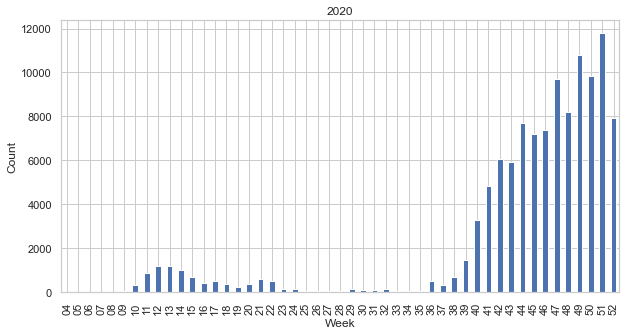

In [32]:
df_cases_dateDim_2020 = df_cases_dateDim_drillDownWeek[df_cases_dateDim_drillDownWeek['year']=='2020']
df_cases_dateDim_2020 = df_cases_dateDim_2020.groupby(['week_number'])['cases_new'].sum()

df_cases_dateDim_2020.plot(kind='bar', title='2020', ylabel='Count', xlabel='Week', figsize=(10, 5))

<AxesSubplot:title={'center':'2021'}, xlabel='Week', ylabel='Count'>

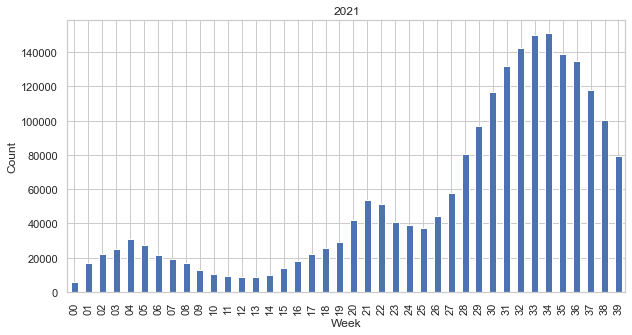

In [33]:
df_cases_dateDim_2021 = df_cases_dateDim_drillDownWeek[df_cases_dateDim_drillDownWeek['year']=='2021']
df_cases_dateDim_2021 = df_cases_dateDim_2021.groupby(['week_number'])['cases_new'].sum()

df_cases_dateDim_2021.plot(kind='bar', title='2021', ylabel='Count', xlabel='Week', figsize=(10, 5))

<AxesSubplot:xlabel='Day', ylabel='Count'>

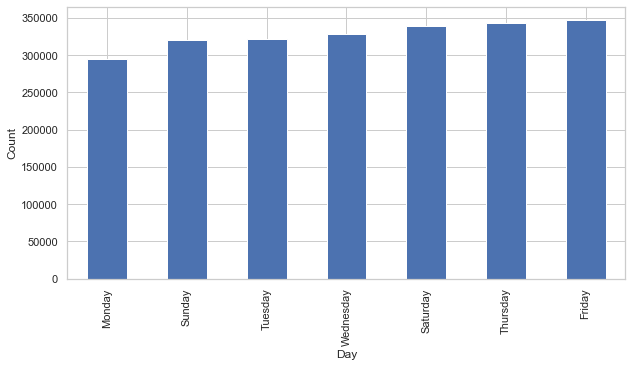

In [34]:
df_cases_dateDim_weekday = df_cases_dateDim.groupby(['weekday_name'])['cases_new'].sum()
df_cases_dateDim_weekday.sort_values(inplace=True)

df_cases_dateDim_weekday.plot(kind='bar', title='', ylabel='Count', xlabel='Day', figsize=(10, 5))

<AxesSubplot:title={'center':'2020'}, xlabel='Month', ylabel='Count'>

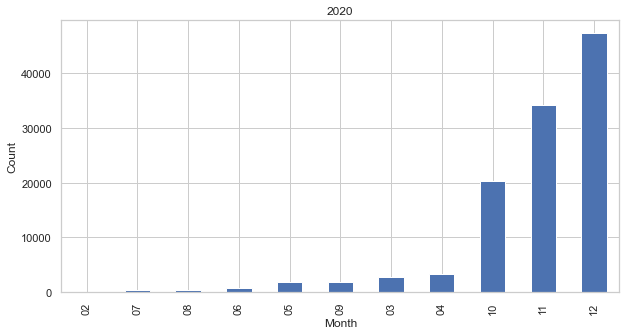

In [35]:
df_cases_dateDim_2020 = df_cases_dateDim[df_cases_dateDim['year']=='2020']
df_cases_dateDim_2020 = df_cases_dateDim_2020[df_cases_dateDim_2020['month_number']!='01']
df_cases_dateDim_2020 = df_cases_dateDim_2020.groupby(['month_number'])['cases_new'].sum()
df_cases_dateDim_2020.sort_values(inplace=True)

df_cases_dateDim_2020.plot(kind='bar', title='2020', ylabel='Count', xlabel='Month', figsize=(10, 5))

<AxesSubplot:title={'center':'2021'}, xlabel='Month', ylabel='Count'>

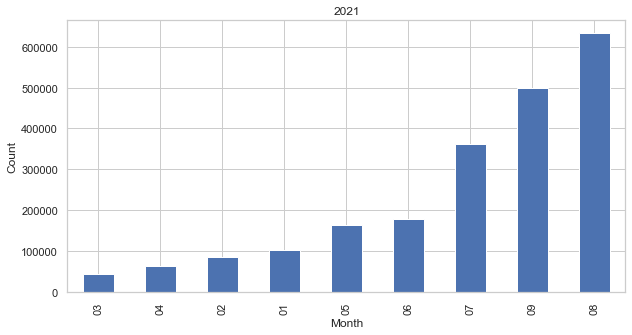

In [36]:
df_cases_dateDim_2021 = df_cases_dateDim[df_cases_dateDim['year']=='2021']
df_cases_dateDim_2021 = df_cases_dateDim_2021[df_cases_dateDim_2021['month_number']!='10']
df_cases_dateDim_2021 = df_cases_dateDim_2021.groupby(['month_number'])['cases_new'].sum()
df_cases_dateDim_2021.sort_values(inplace=True)

df_cases_dateDim_2021.plot(kind='bar', title='2021', ylabel='Count', xlabel='Month', figsize=(10, 5))

### EDA 3: What is the stationarity of the time-series dataset?

##### Time Series Analysis

Watch this moving average and window rolling tutorials
<br>
youtube https://www.youtube.com/watch?v=T2mQiesnx8s
<br>
Source code https://nbviewer.org/urls/alphabench.com/data/pandas_rolling_method.ipynb

In [37]:
# malaysia cases
df_cases_my = cases_malaysia[['date','cases_new','cases_recovered','cases_active']]
df_cases_my

,date,cases_new,cases_recovered,cases_active
0,2020-01-25,4,0,4
1,2020-01-26,0,0,4
2,2020-01-27,0,0,4
3,2020-01-28,0,0,4
4,2020-01-29,3,0,7
...,...,...,...,...
615,2021-10-01,11889,15891,160144
616,2021-10-02,10915,15396,155578
617,2021-10-03,9066,14454,150146
618,2021-10-04,8075,15456,142746


In [38]:
df_ma = df_cases_my.copy()
df_ma['MA_3'] = df_ma.cases_new.rolling(3).mean()#.shift() # shift it to next day for forecasting purpose
df_ma['MA_5'] = df_ma.cases_new.rolling(5).mean()
df_ma['MA_7'] = df_ma.cases_new.rolling(7).mean()
df_ma['STD_7'] = df_ma.cases_new.rolling(7).std()

df_ma

,date,cases_new,cases_recovered,cases_active,MA_3,MA_5,MA_7,STD_7
0,2020-01-25,4,0,4,NaN,NaN,NaN,NaN
1,2020-01-26,0,0,4,NaN,NaN,NaN,NaN
2,2020-01-27,0,0,4,1.333333,NaN,NaN,NaN
3,2020-01-28,0,0,4,0.000000,NaN,NaN,NaN
4,2020-01-29,3,0,7,1.000000,1.4,NaN,NaN
...,...,...,...,...,...,...,...,...
615,2021-10-01,11889,15891,160144,12352.666667,11869.8,12336.000000,1025.146494
616,2021-10-02,10915,15396,155578,11846.333333,11861.0,11909.714286,876.526043
617,2021-10-03,9066,14454,150146,10623.333333,11407.8,11332.857143,1220.712282
618,2021-10-04,8075,15456,142746,9352.000000,10536.0,10920.857143,1742.913598


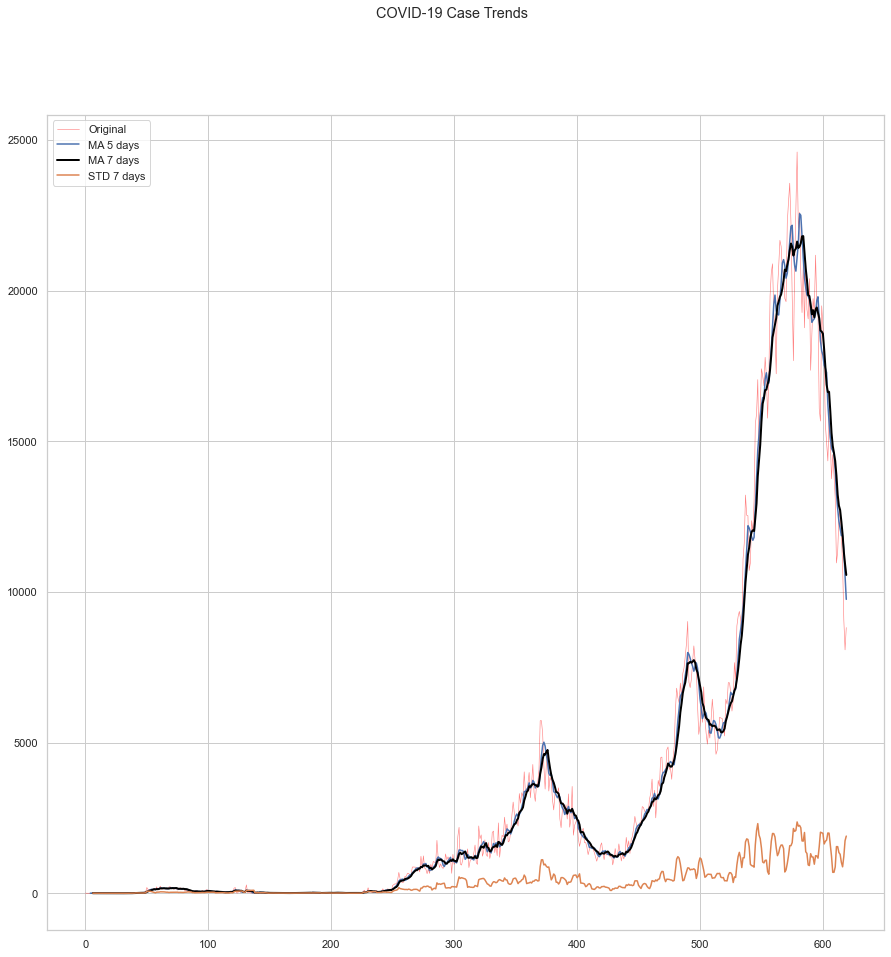

In [39]:
plt.figure(figsize=(15,15))
plt.grid(True)
plt.suptitle('COVID-19 Case Trends')
plt.plot(df_ma['cases_new'], label='Original', color='red', linewidth =0.6, alpha = 0.5)
plt.plot(df_ma['MA_5'], label='MA 5 days')
plt.plot(df_ma['MA_7'], label='MA 7 days', color='black', linewidth =2)
plt.plot(df_ma['STD_7'], label='STD 7 days')
plt.legend(loc=2)

In [40]:
# plt.figure(figsize=(15, 5))
# plt.suptitle('COVID-19 Case Trends')

# temp['cases_new'].plot(legend=None, color='red', label="cases new", linewidth =0.8, alpha = 0.5)
# temp['cases_new_norm_ma'].plot(legend=None, color='black', label="cases new mov avg")

# plt.legend()

In [41]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries, df, windowNumber=12):
    
    # Determine rolling statistics
    movingAverage = timeseries.rolling(window=windowNumber).mean()
    movingSTD = timeseries.rolling(window=windowNumber).std()
    
    # Plot rolling statistics
    orig = plt.plot(timeseries.iloc[:,1:], color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # perfrom dickey fuller test:
    print('Reuslts of Dickey-Fuller Test:')
    dftest = adfuller(df, autolag='AIC') #AIC is a matrix
    dfoutput = pd.Series(dftest[:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

    print(dfoutput)
    # p-value should be less
    # critical value > test statistic

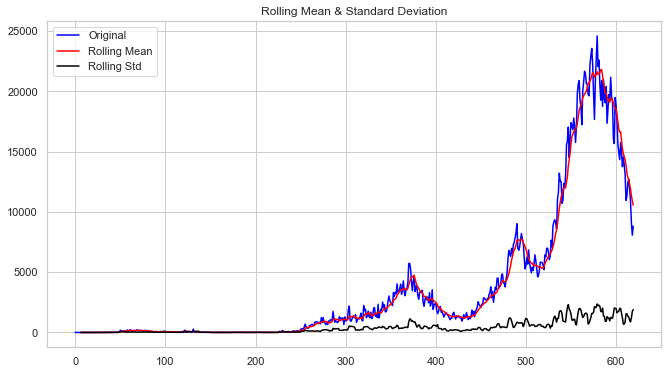

Reuslts of Dickey-Fuller Test:
Test Statistic                  -2.878612
p-value                          0.047892
#Lags Used                      19.000000
Number of Observations Used    600.000000
Critical Value (1%)             -3.441296
Critical Value (5%)             -2.866369
Critical Value (10%)            -2.569342
dtype: float64


In [42]:
test_stationarity(df_ma[['date','cases_new']], df_ma['cases_new'], 7)

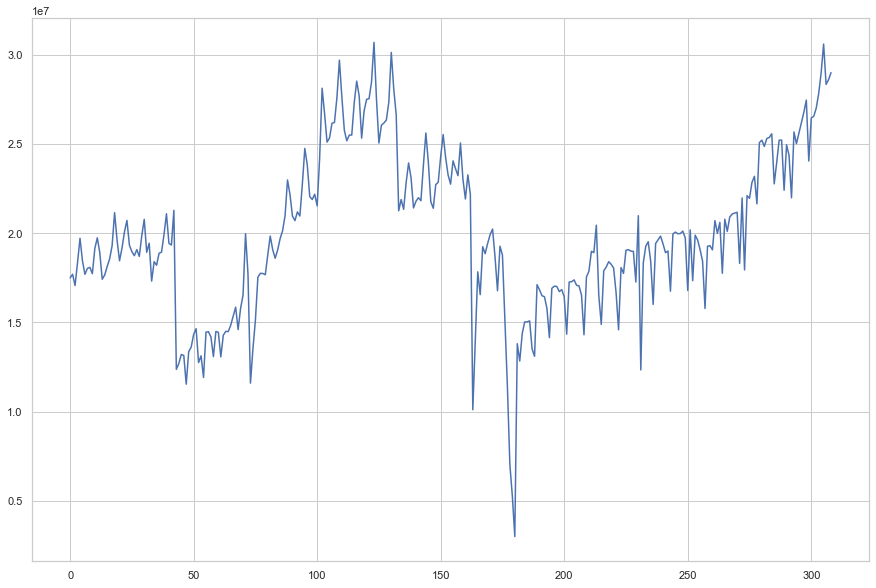

In [43]:
df_checkins = checkin_malaysia[['date','checkins']]
plt.figure(figsize=(15,10))
plt.grid(True)
plt.plot(df_checkins['checkins'],label='Cases New')
plt.show()

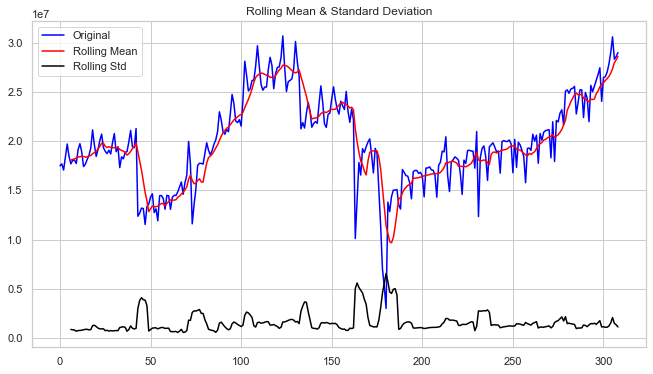

Reuslts of Dickey-Fuller Test:
Test Statistic                  -1.134774
p-value                          0.701007
#Lags Used                      14.000000
Number of Observations Used    294.000000
Critical Value (1%)             -3.452790
Critical Value (5%)             -2.871422
Critical Value (10%)            -2.572035
dtype: float64


In [44]:
test_stationarity(df_checkins[['date','checkins']], df_checkins['checkins'], 7)

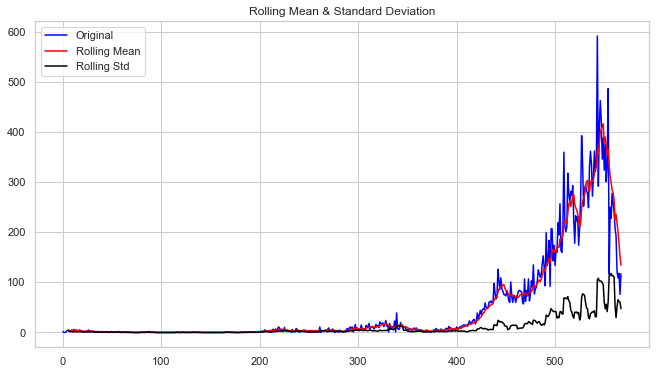

Reuslts of Dickey-Fuller Test:
Test Statistic                  -3.412172
p-value                          0.010551
#Lags Used                      19.000000
Number of Observations Used    548.000000
Critical Value (1%)             -3.442339
Critical Value (5%)             -2.866829
Critical Value (10%)            -2.569587
dtype: float64


In [45]:
test_stationarity(deaths_malaysia[['date','deaths_new']], deaths_malaysia['deaths_new'], 7)

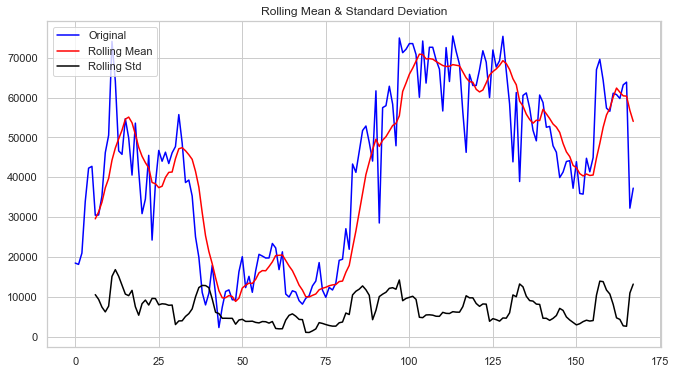

Reuslts of Dickey-Fuller Test:
Test Statistic                  -2.089453
p-value                          0.248777
#Lags Used                       7.000000
Number of Observations Used    160.000000
Critical Value (1%)             -3.471896
Critical Value (5%)             -2.879780
Critical Value (10%)            -2.576495
dtype: float64


In [46]:
test_stationarity(trace_malaysia[['date','casual_contacts']], trace_malaysia['casual_contacts'], 7)

This dataset is non-stationary as it has moving mean and variance

#### Time Series and Statsmodels

[Stationairty](https://www.youtube.com/watch?v=oY-j2Wof51c)
<br>
Stationarity determine what predictive models you could use. The data is stationary if
<br>
- Mean is const
- Variance is const (less fluctuation)
- No seasonality
<br>
White noise also means it is stationary, but if it's stationary it not neccessary is white noise.

[statsmodels.tsa.stattools.adfuller](https://docs.w3cub.com/statsmodels/generated/statsmodels.tsa.stattools.adfuller)

[Revision about test statistic, p-value and critical value](https://towardsdatascience.com/statistical-tests-when-to-use-which-704557554740#:~:text=Relationship%20between%20p%2Dvalue%2C%20critical,Z%2C%20T%20or%20chi)

### EDA 4: What are the vaccination and registration rates per state in Malaysia?

In [47]:
ppl = population.copy()
df = vax_state.groupby('state')['daily_full'].sum()
column = df.keys()
ppl.drop(0,axis=0,inplace=True)
state = []
ratio = []
for i in column:
    ppl_num = ppl[ppl['state']==i]['pop'].sum()
    vax_num = vax_state[vax_state['state']==i]['daily_full'].sum()
    cal = vax_num/ppl_num * 100
    state.append(i)
    ratio.append(cal)
df = pd.DataFrame(data=ratio,index=state)
df.reset_index(inplace=True)
df.rename(columns={'index':'state',0:'percentage'},inplace=True)
           

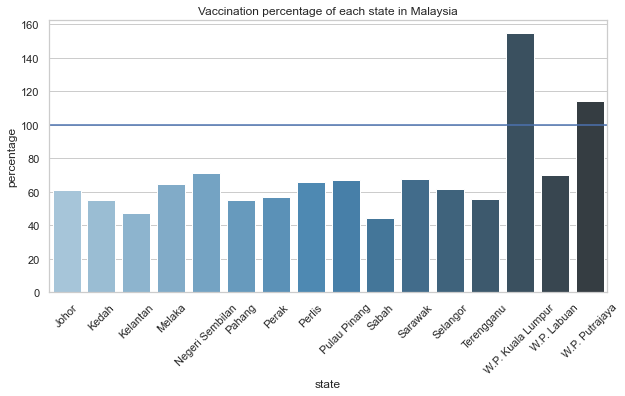

In [48]:
plt.figure(figsize=(10, 5))
graph=sns.barplot(x='state', y='percentage', data=df, palette='Blues_d')
graph.axhline(100)


plt.xticks(rotation=45)
plt.title('Vaccination percentage of each state in Malaysia')
plt.show()

In [49]:
# interactive plot
#fig = px.bar(df,x='state',y='ratio')
#fig.show()  

In [50]:
df = vaxreg_state.groupby('state')['total'].max()
column = df.keys()
state = []
ratio = []
for i in column:
    ppl_num = ppl[ppl['state']==i]['pop']
    vax_num = vaxreg_state[vaxreg_state['state']==i]['total'].max()
    cal = vax_num/ppl_num * 100
    state.append(i)
    ratio.append(int(cal))
df = pd.DataFrame(data=ratio,index=state)
df.reset_index(inplace=True)
df.rename(columns={'index':'state',0:'percentage'},inplace=True)

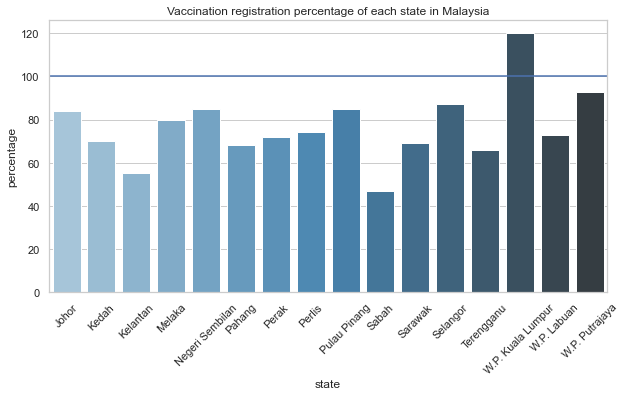

In [51]:
plt.figure(figsize=(10, 5))
graph = sns.barplot(x='state', y='percentage', data=df, palette='Blues_d')
graph.axhline(100)

plt.xticks(rotation=45)
plt.title('Vaccination registration percentage of each state in Malaysia')
plt.show()

In [52]:
# interactive plot
#fig = px.bar(df,x='state',y='ratio')
#fig.show()    

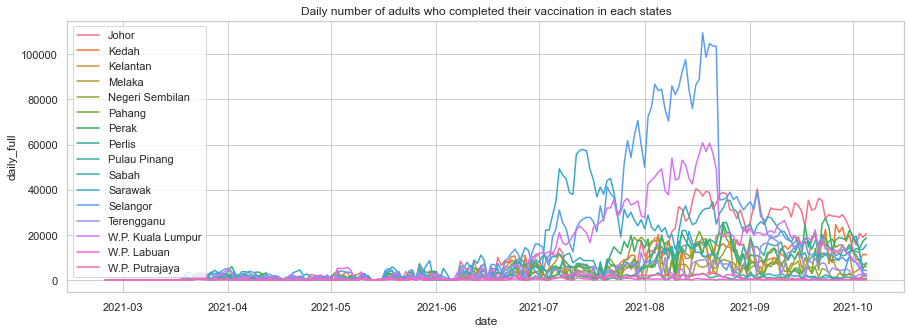

In [53]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=vax_state, x='date', y='daily_full', hue='state')
plt.legend()
plt.title('Daily number of adults who completed their vaccination in each states')
plt.show()

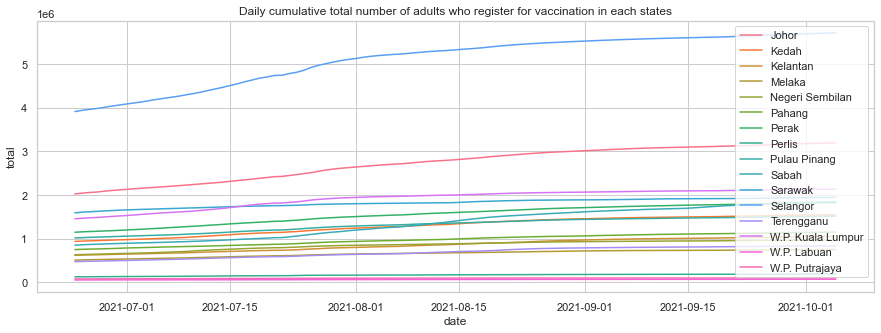

In [54]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=vaxreg_state, x='date', y='total', hue='state')
plt.legend()
plt.title('Daily cumulative total number of adults who register for vaccination in each states')
plt.show()

In [55]:
# interactive plot (using plotly)
#fig1 = px.line(vax_state, x="date", y="daily_full", color='state')
#fig1.show()
#fig2 = px.line(vaxreg_state, x="date", y="total", color='state')
#fig2.show()

### EDA 5: What are the types and total number of side effects for each type of vaccine?

In [56]:
df = vax_malaysia[['pfizer1', 'pfizer2','sinovac1', 'sinovac2', 'astra1', 'astra2', 'cansino']].sum()
df = pd.DataFrame(df)
df.reset_index(inplace=True)
df = df.rename(columns={'index':'dose',0:'total'})
df['vaxtype'] = ['pfizer','pfizer','sinovac','sinovac','astra','astra','cansino']

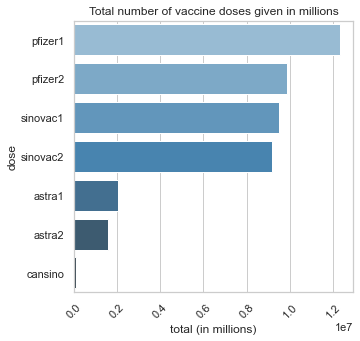

In [57]:
plt.figure(figsize=(5, 5))
sns.barplot(x='total', y='dose', data=df, palette='Blues_d')
plt.xticks(rotation=45)
plt.xlabel('total (in millions)')
plt.title('Total number of vaccine doses given in millions')
plt.show()

In [58]:
# interactive plot (using plotly)
#fig1 = px.bar(df,x='total',y='dose')
#fig1.show()

In [59]:
df = aefi[['vaxtype','d1_site_pain','d1_site_swelling','d1_site_redness','d1_tiredness','d1_headache','d1_muscle_pain','d1_joint_pain','d1_weakness', 'd1_fever','d1_vomiting','d1_chills','d1_rash','d2_site_pain','d2_site_swelling','d2_site_redness','d2_tiredness','d2_headache','d2_muscle_pain','d2_joint_pain','d2_weakness', 'd2_fever','d2_vomiting','d2_chills','d2_rash']].copy()
df = df.groupby('vaxtype').sum()
df2 = aefi_serious.groupby('vaxtype').sum()


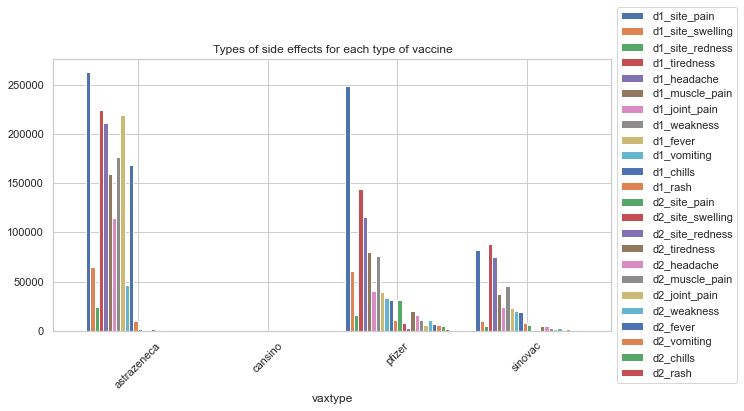

In [60]:
df.plot.bar(figsize=(10, 5), width=0.8)
plt.title('Types of side effects for each type of vaccine')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(rotation=45)
plt.show()

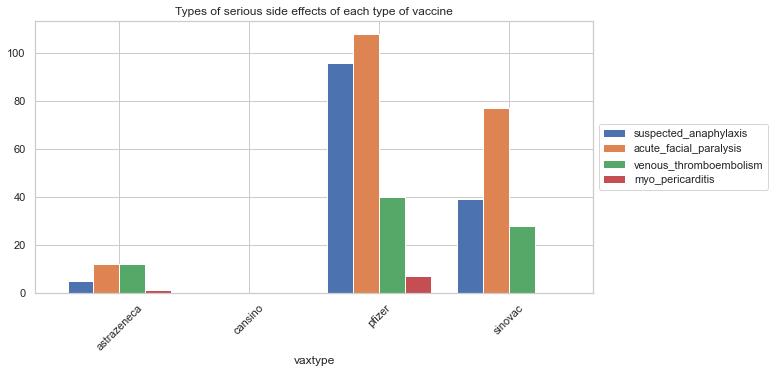

In [61]:
df2.plot.bar(figsize=(10, 5), width=0.8)
plt.title('Types of serious side effects of each type of vaccine')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(rotation=45)
plt.show()

In [62]:
# interactive plot (using plotly)
#fig1 = px.bar(df,barmode='group',title = 'side effect of each type of vaccine')
#fig2 = px.bar(df2,barmode='group',title = 'serious side effect of each type of vaccine')
#fig1.show()
#fig2.show()

### EDA 6: Which type of vaccine is given to more people?

In [63]:
df

,d1_site_pain,d1_site_swelling,d1_site_redness,d1_tiredness,d1_headache,d1_muscle_pain,d1_joint_pain,d1_weakness,d1_fever,d1_vomiting,...,d2_site_redness,d2_tiredness,d2_headache,d2_muscle_pain,d2_joint_pain,d2_weakness,d2_fever,d2_vomiting,d2_chills,d2_rash
vaxtype,,,,,,,,,,,,,,,,,,,,,
astrazeneca,262941,64947,23704,224269,210573,159350,114575,176252,218685,46574,...,122,1318,1173,673,407,759,529,297,445,56
cansino,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pfizer,248145,60653,15879,143623,115331,79838,40099,76394,39511,32859,...,2393,19730,16124,11286,6053,11221,6409,5506,5232,1697
sinovac,81887,9631,4758,88212,74537,37701,23959,45551,23099,20210,...,481,5117,4639,2350,1502,2778,1138,1377,954,475


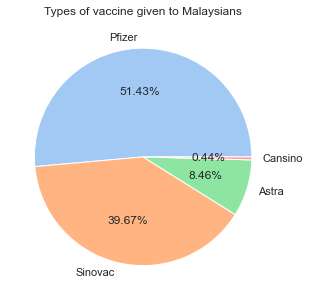

In [64]:
df = vax_malaysia[['pfizer1','sinovac1','astra1','cansino']]
df = df.rename(columns={'pfizer1':'Pfizer','sinovac1':'Sinovac','astra1':'Astra', 'cansino':'Cansino'})
df = df.sum()
df = pd.DataFrame(df)
df = df.reset_index()
df = df.rename(columns={'index':'vaxtype',0:'total'})

colors = sns.color_palette('pastel')[0:5]
plt.figure(figsize=(5, 5))
plt.pie(df['total'], labels=df['vaxtype'], colors=colors, autopct='%.2f%%')
plt.title('Types of vaccine given to Malaysians')
plt.show()

In [65]:
# interactive plot (using plotly)
#fig = px.pie(df, values='total', names='vaxtype',title='Rate of each vaccine in Malaysia',color_discrete_sequence=px.colors.sequential.RdBu)
#fig.show()

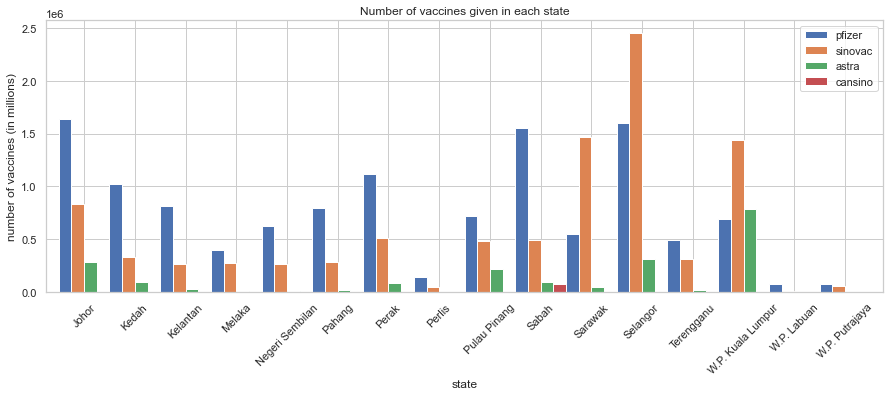

In [66]:
df = vax_state[['state','pfizer1','sinovac1','astra1','cansino']]
df = df.rename(columns={'pfizer1':'pfizer','sinovac1':'sinovac','astra1':'astra'})
df = df.groupby('state').sum()

df.plot.bar(figsize=(15, 5), width=1)
plt.title('Number of vaccines given in each state')
plt.xticks(rotation=45)
plt.ylabel('number of vaccines (in millions)')
plt.show()

In [67]:
# interactive plot (using plotly)
#fig = px.bar(df,barmode='group',title = 'Vaccine in each state')
#fig.show()

### EDA 7:   Which states are recovering? Which of the states shows a decrease in the number of COVID-19 cases?

Since the number of vaccinated entities are increasing, there is a significant decrease in the number of COVID-19 cases in each state. By plotting the moving average of daily confirmed cases and the cumulative number of vaccinated persons against the dates, we can observe that there is a downward trend after the vaccination has reached a certain level in each of the states. The moving average of daily cases is obtained by averaging the number of daily cases in the past 7 days. 

To calculate the daily cumulative number of vaccinated persons, we start by calculating the number of people who completed their vaccination dose. This includes adding the 
* daily number of adults who has completed their 2nd dose of vaccine (either Pfizer, Sinovac or Astra)
* daily number of adults who has taken Cansino (since Cansino only requires 1 dose)
* daily number of children who complete their 2nd dose of Pfizer

These numbers are accumulated to obtain the daily cumulative number of vaccinated persons.


In [68]:
# creating a function to plot 
def plot_cases_vax(state):
   
    # get vaccination status of state
    vax = vax_state[vax_state['state'] == state].copy()
    vax['cumul_cansino'] = vax['cansino'].cumsum()
    vax['cumul_total_vax'] = vax['cumul_full'] + vax['cumul_cansino'] + vax['cumul_full_child'] 
    vax = vax[['date', 'daily', 'cumul_total_vax']].copy()
    vax['date'] = vax['date'].astype('datetime64[ns]')

    # get covid cases of state
    case = cases_state[cases_state['state'] == state][['date', 'cases_new']].copy()
    case['date'] = case['date'].astype('datetime64[ns]')

    # merging both dataframes
    vax_status = pd.merge(vax, case, on='date', how='inner', indicator=True)
    vax_status.drop(['_merge'], axis=1, inplace=True)

    # working on vaccination status
    pop = population.loc[population['state'] == state, 'pop'].values[0]
    
    vax_status['cumul_total_vax_norm'] = vax_status['cumul_total_vax']/pop
    vax_status['cases_new_norm']=(vax_status['cases_new']-vax_status['cases_new'].min())/(vax_status['cases_new'].max()-vax_status['cases_new'].min())
    vax_status['cases_new_ma'] = vax_status['cases_new_norm'].rolling(window=7).mean()
    
    vax_status = vax_status.dropna()
    
    plt.figure(figsize = (20,5))

    plt.plot(vax_status['date'], vax_status['cases_new_norm'], color='pink', label='Daily Confirmed New Cases', linestyle='--') 
    plt.plot(vax_status['date'], vax_status['cases_new_ma'], color='red', label='Daily Confirmed New Cases (7-day Moving Average)') 
    plt.plot(vax_status['date'], vax_status['cumul_total_vax_norm'], color='blue', label='Normalized Cumulative Number of Vaccinated Person') 
    plt.plot(vax_status['date'], pd.Series([1 for i in range(218)]), color='lightgreen', label='State Population', linestyle='--') 
    
    # labeling the date
    x = vax_status['date']
    y = vax_status['cases_new_ma']
    xmax = x[np.argmax(y)]
    ymax = y.max()
    text= "{:%Y-%m-%d}".format(xmax)

    plt.annotate(text, xy=(xmax+timedelta(days=6), ymax), xytext=(xmax, ymax+0.15),
                 arrowprops=dict(facecolor='black', shrink=0.05))
    
    # labeling the % of vaccinated people
    y_2 = vax_status['cumul_total_vax_norm']    
    y_val = y_2[np.argmax(y)]
    text_2= "{:.2f}%".format(y_val*100)

    plt.annotate(text_2, xy=(xmax+timedelta(days=6), y_val+0.05), xytext=(xmax++timedelta(days=4), y_val-0.15),
                 arrowprops=dict(facecolor='black', shrink=0.05))
    
    
    plt.title(state)
    plt.legend()


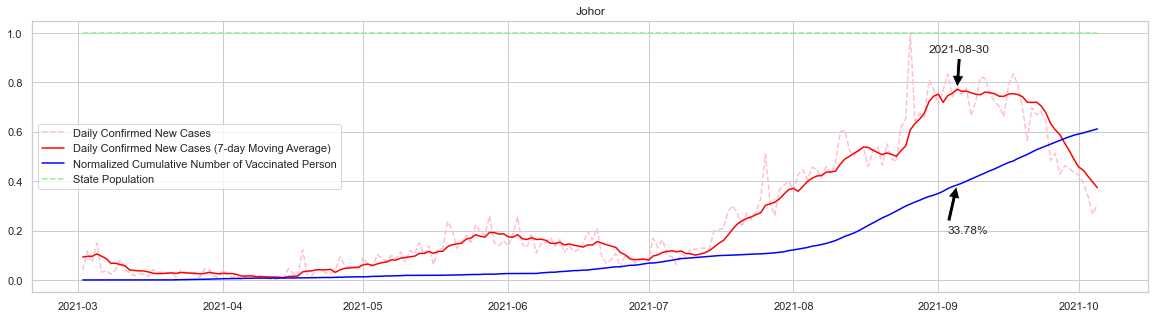

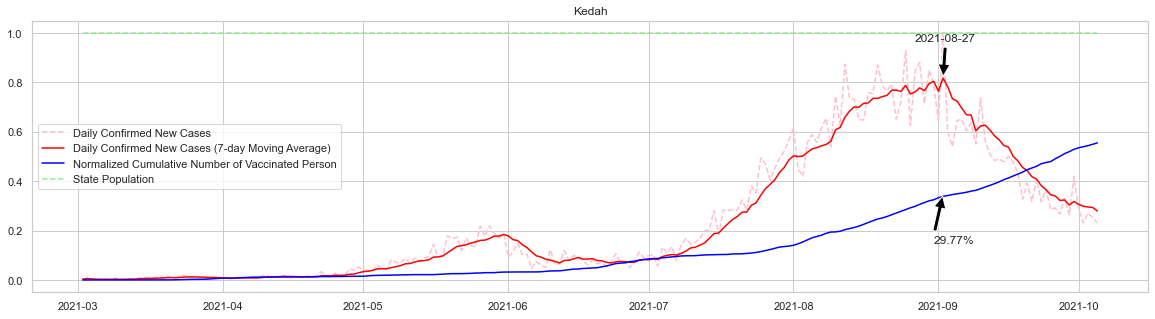

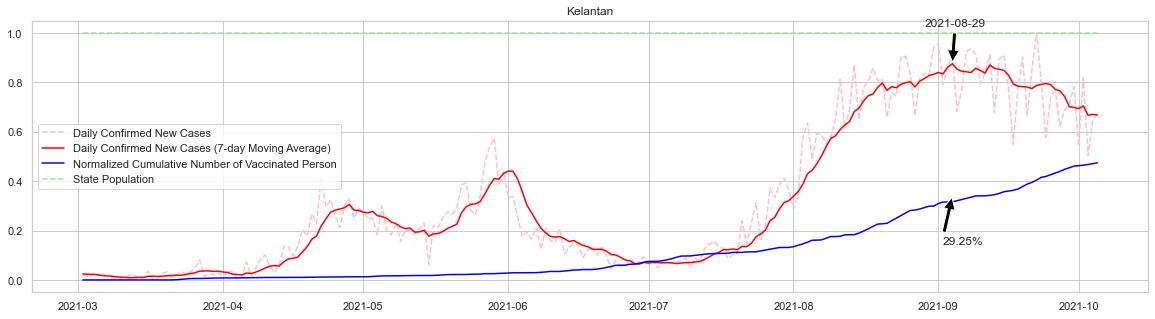

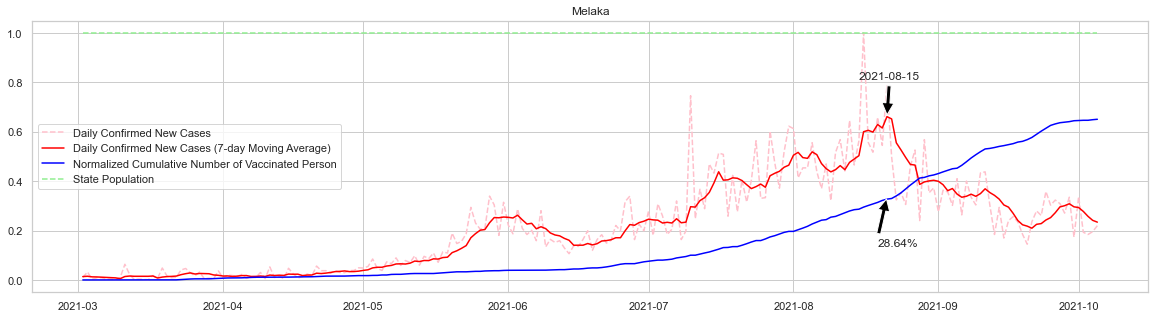

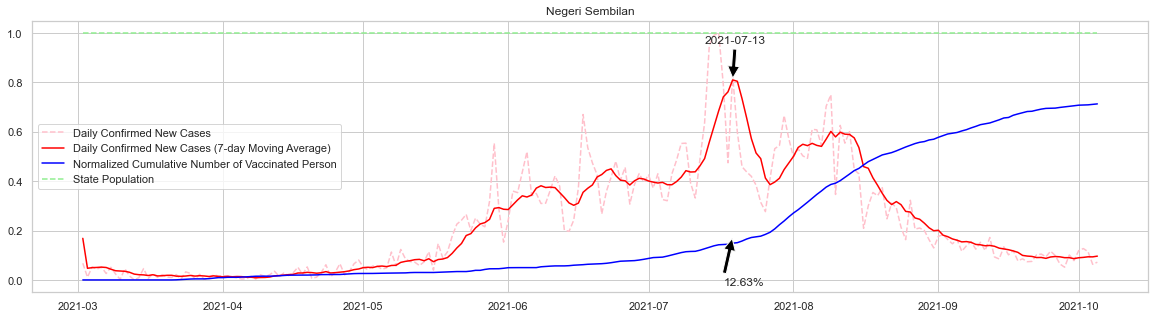

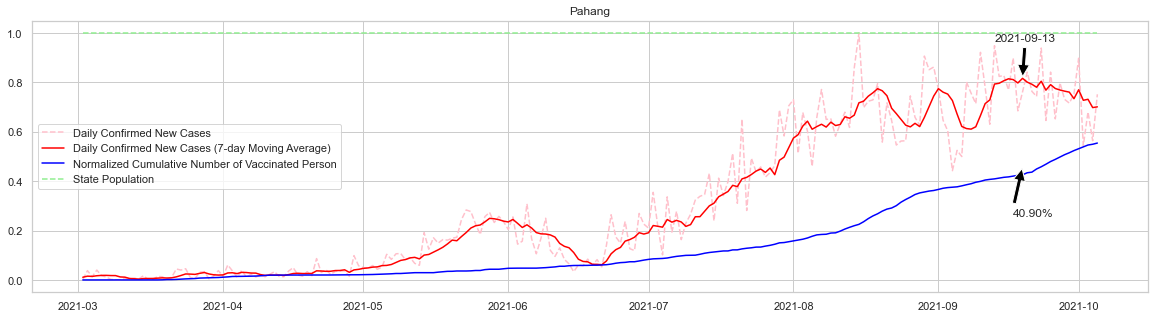

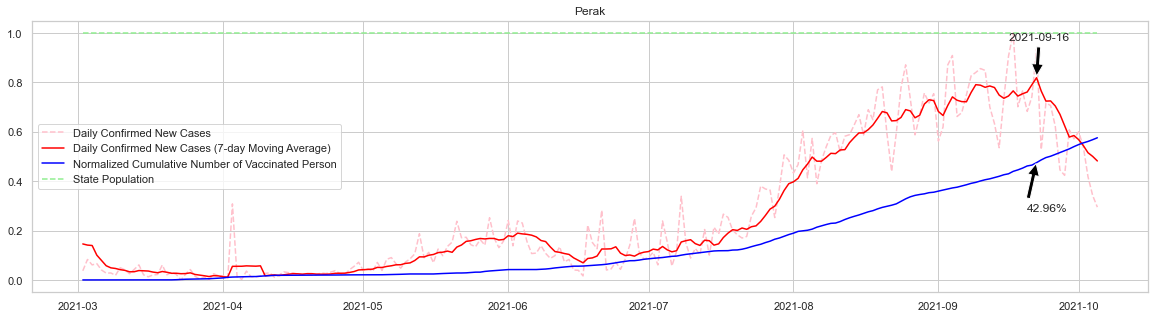

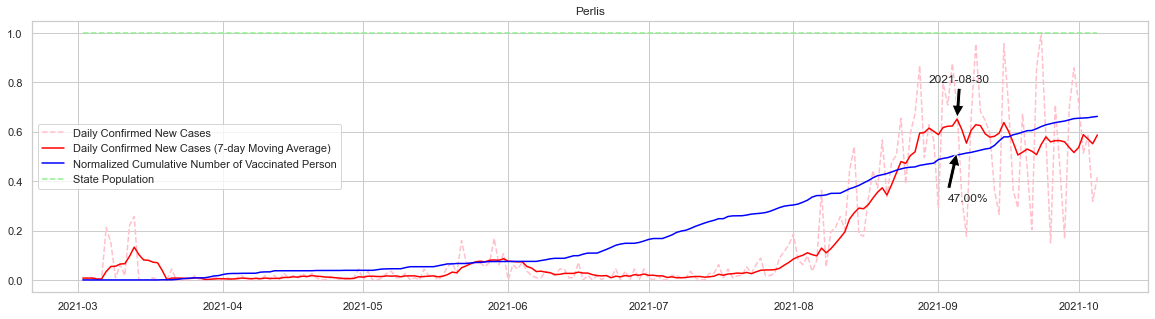

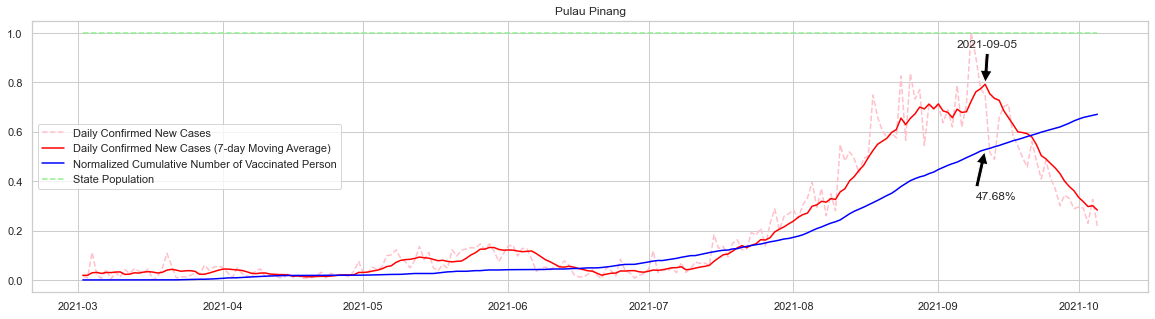

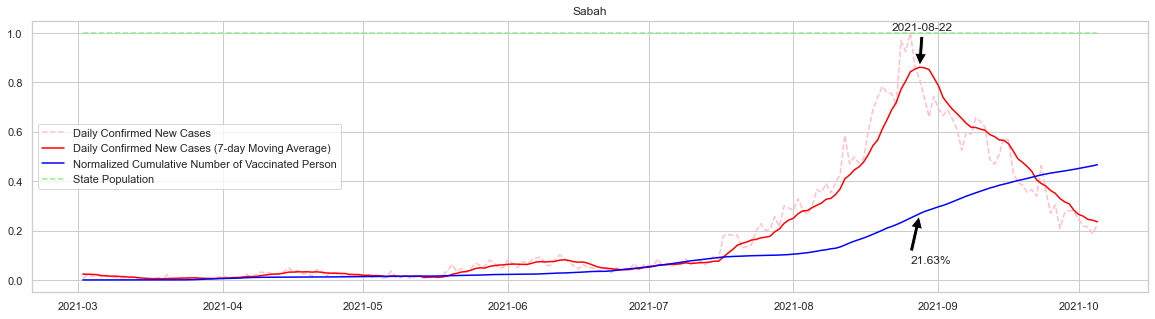

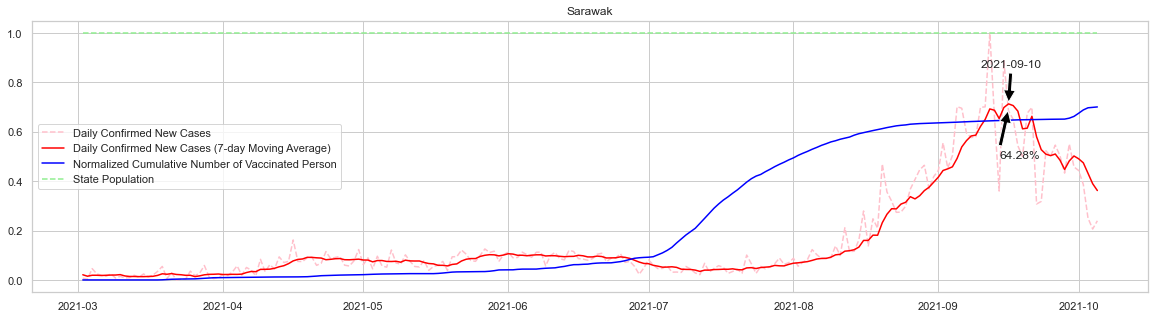

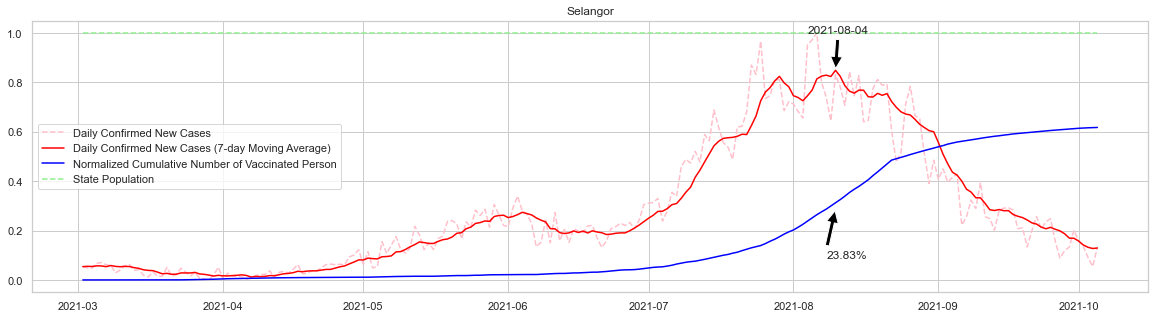

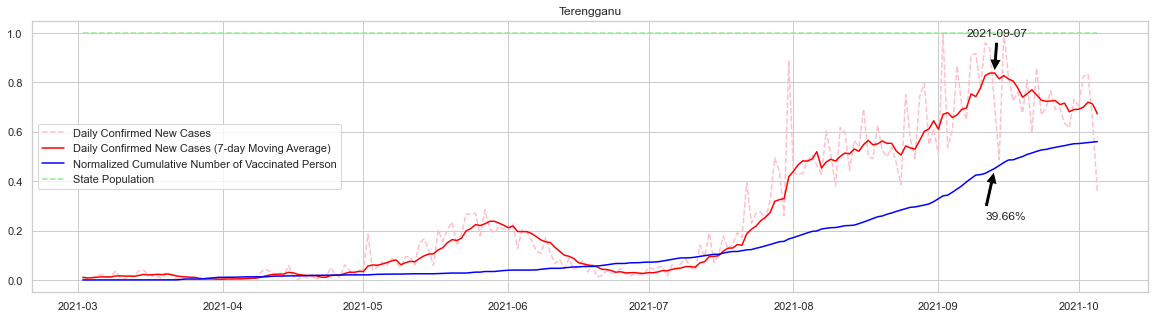

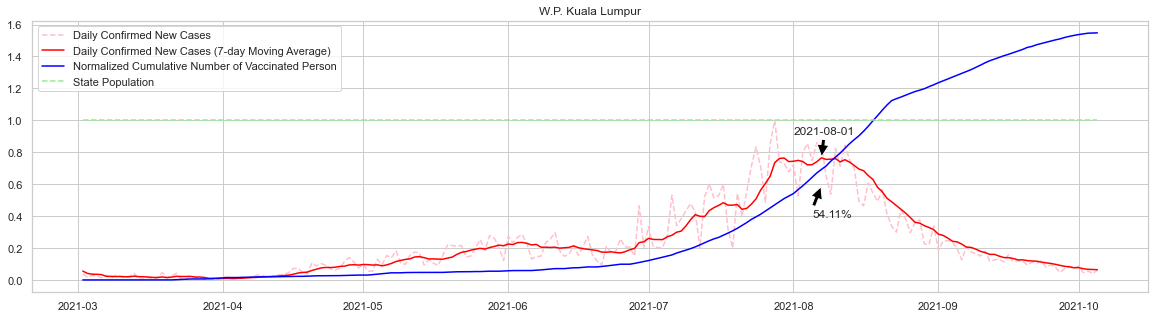

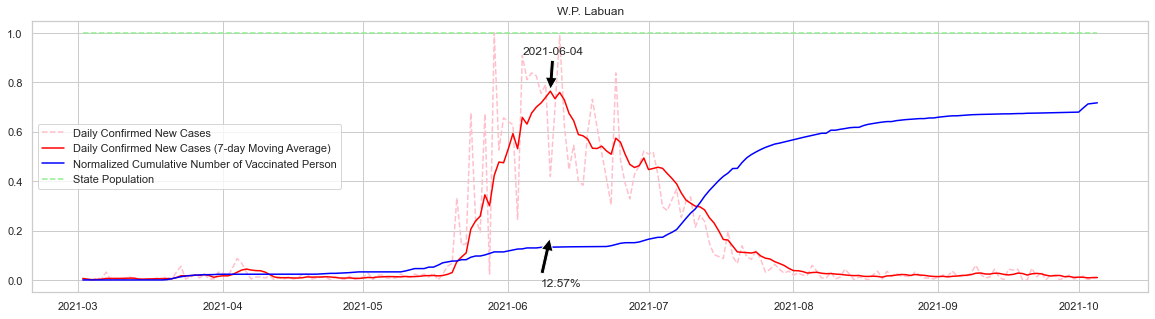

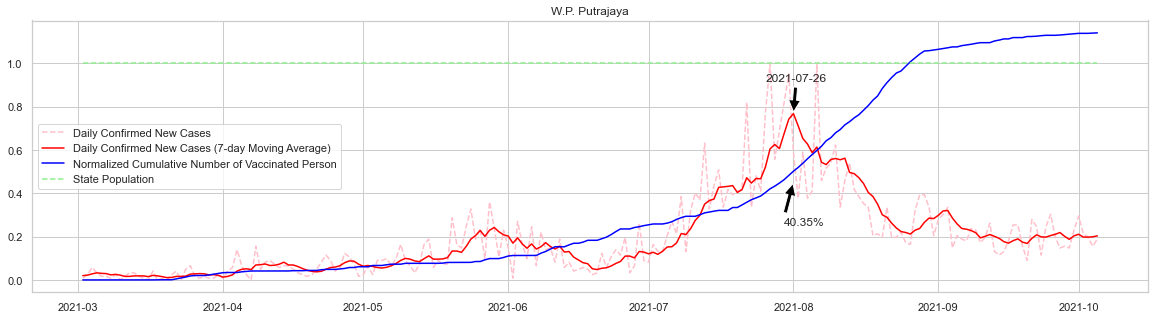

In [69]:
states = vax_state['state'].unique()

for state in states:
    plot_cases_vax(state)

It is observed that the number of vaccinated people in some states has exceeded their state population. The two states that have this phenomena are Kuala Lumpur and Putrajaya. This might be due to foreigners receiving their vaccination shot in our country.

### EDA 8: When is the time of the day with most check-ins?

checkin_malaysia_time.csv records the time distribution of daily check-ins on MySejahtera at the country level. The data records the number of check-ins nationwide in every 30 minutes interval.

By summing up each column in the dataset, we can obtain the total number of check-ins at each 30 minutes between 2020-12-01 to 2021-10-05, spanning over 309 days.


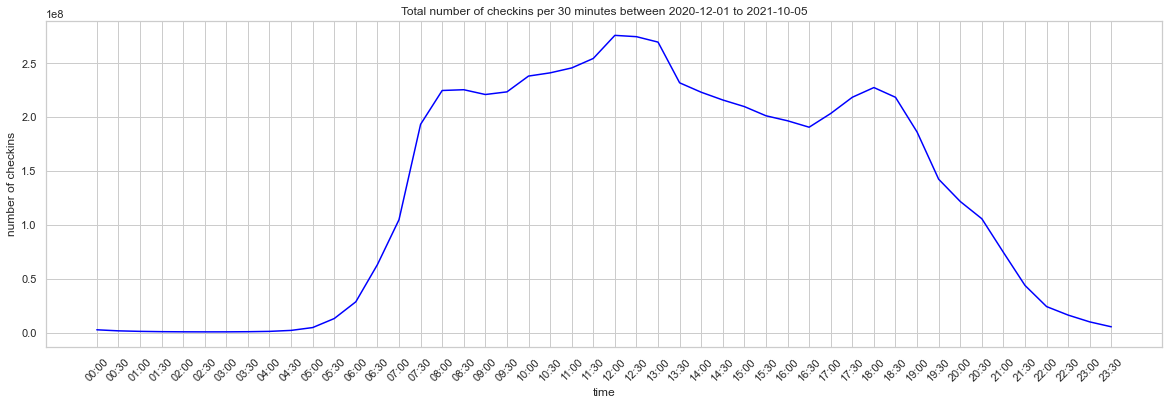

In [70]:
checkin_time = pd.DataFrame(checkin_malaysia_time[[str(x) for x in range(48)]].sum())
time = []
for x in range(24):
    time.extend([f'{x:02d}:00', f'{x:02d}:30'])
checkin_time.insert(0, 'time', time, True)
checkin_time.rename(columns={0: 'checkins'}, inplace=True)

plt.figure(figsize = (20,6))
plt.plot(checkin_time['time'], checkin_time['checkins'], color='blue')
plt.title('Total number of checkins per 30 minutes between 2020-12-01 to 2021-10-05')
plt.xlabel('time')
plt.ylabel('number of checkins')
plt.xticks(rotation=45)
plt.show()

In [71]:
# interactive plot (using plotly)
#fig = px.line(checkin_time, x='time', y='total number of checkins')
#fig.update_xaxes(tickangle=270) # rotate 270
#fig.update_layout(title='Total number of checkins per 30 minutes between 2020-12-01 to 2021-10-05')
#fig.show()

From the plot above, we can roughly observe 3 peaks, which are around **8am**, **12pm**, and **6pm** respectively. Presumeably these are the preferred hours for Malaysians to buy their meals. 


### EDA 9: What are the dates with the highest number of checkins? How does it correlate with the number of cases and deaths during the day?

In [72]:
cases_malaysia['date'] = cases_malaysia['date'].astype('datetime64[ns]')
tests_malaysia['date'] = tests_malaysia['date'].astype('datetime64[ns]')
deaths_malaysia['date'] = deaths_malaysia['date'].astype('datetime64[ns]')

In [73]:
# merge cases_state and tests_state together
df_cases_tests = (pd.merge(cases_malaysia, tests_malaysia, on='date', how='inner', indicator=True)).set_index('date')
df_cases_tests.drop(['_merge'], axis=1, inplace=True)

# merge deaths_sta
df_cases_tests_deaths = (pd.merge(df_cases_tests, deaths_malaysia, on='date', how='inner', indicator=True)).set_index('date')
df_cases_tests_deaths.drop(['_merge'], axis=1, inplace=True)

# merge checkins
df_all = (pd.merge(df_cases_tests_deaths, checkin_malaysia, on='date', how='inner', indicator=True)).set_index('date')
df_all.drop(['_merge'], axis=1, inplace=True)

# reset index
df_all.reset_index(inplace = True)

In [74]:
def minmaxnorm(col):
    return ( (col-col.min()) / (col.max()-col.min()) )

df_9 = df_all[['date', 'cases_new', 'deaths_new', 'rtk-ag', 'pcr', 'checkins']].copy() # df for eda 9
df_9['cases_norm'] = minmaxnorm(df_9['cases_new'])
df_9['deaths_norm'] = minmaxnorm(df_9['deaths_new'])

df_9['tests_new'] = df_9['rtk-ag'] + df_9['pcr']
df_9['tests_norm'] = minmaxnorm(df_9['tests_new'])
df_9['checkins_norm'] = minmaxnorm(df_9['checkins'])
df_9.head()

,date,cases_new,deaths_new,rtk-ag,pcr,checkins,cases_norm,deaths_norm,tests_new,tests_norm,checkins_norm
0,2020-12-01,1472,2,7347,16024,17492265,0.026150,0.003378,23371,0.000000,0.523505
1,2020-12-02,851,2,8761,15962,17695726,0.000000,0.003378,24723,0.008564,0.530854
2,2020-12-03,1075,11,10533,21196,17063123,0.009432,0.018581,31729,0.052943,0.508004
3,2020-12-04,1141,0,11457,19657,18350879,0.012212,0.000000,31114,0.049048,0.554519
4,2020-12-05,1123,4,8749,16905,19711082,0.011454,0.006757,25654,0.014462,0.603651


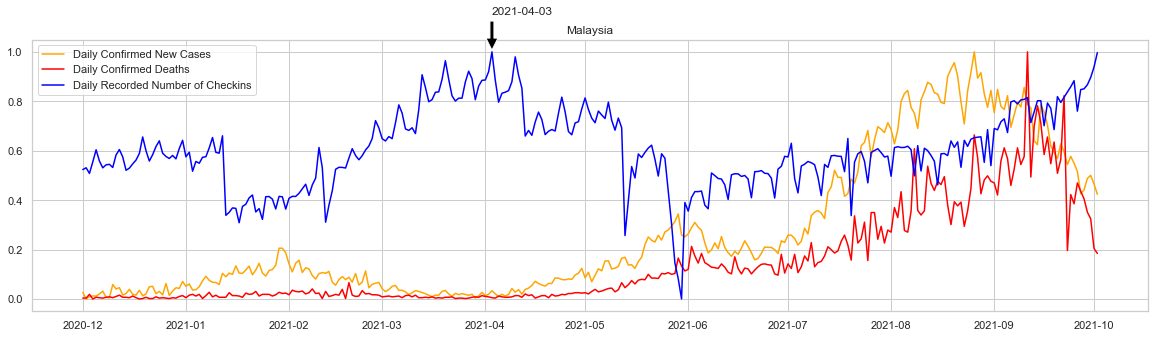

In [75]:
plt.figure(figsize = (20,5))

plt.plot(df_9['date'], df_9['cases_norm'], color='orange', label='Daily Confirmed New Cases') 
plt.plot(df_9['date'], df_9['deaths_norm'], color='red', label='Daily Confirmed Deaths') 
plt.plot(df_9['date'], df_9['checkins_norm'], color='blue', label='Daily Recorded Number of Checkins') 

# labeling the date
x = df_9['date']
y = df_9['checkins_norm']
xmax = x[np.argmax(y)]
ymax = y.max()
text= "{:%Y-%m-%d}".format(xmax)

plt.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax+0.15),arrowprops=dict(facecolor='black', shrink=0.05))

plt.title('Malaysia')
plt.legend()

In [76]:
# interactive plot
#fig = px.line(df_9, x='date', y=['cases_norm', 'deaths_norm', 'checkins_norm'])
#fig.show()

Text(0.5, 1.0, 'Correlation between cases, deaths and checkins')

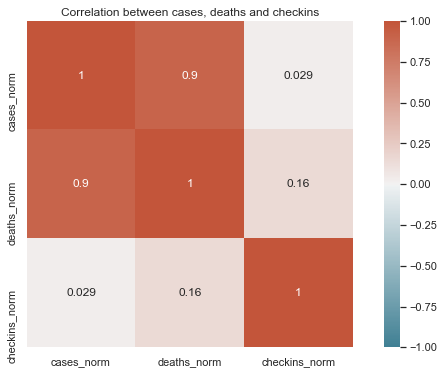

In [77]:
corr_test = df_9[['date', 'cases_norm', 'deaths_norm', 'checkins_norm']].corr()
sns.heatmap(corr_test, square=True, annot=True, vmin=-1, vmax=1, cmap=sns.diverging_palette(220, 20, as_cmap=True))
plt.title('Correlation between cases, deaths and checkins')

The date with the highest number of checkins between 2020-12-01 and 2021-10-02 is 2021-04-03 (the **3rd of April 2021**). On that day, the number of cases and deaths are considerably low. 

In order to visualize the correlation between the daily number of cases and deaths with the daily number of check-ins, we have plotted a heatmap among these 3 attributes. The heatmap shows that there is almost no correlation between them.

### EDA10: Rate of Vaccination Serious Side Effect VS COVID-19 Death Rate, which one is more dangerous?


COVID-19 vaccination side effect vs COVID-19 death rate without vaccine, which is scarier? Why should people take vaccine?

In [78]:
ppl = pd.read_csv('dataset/static/population_moh.csv')

In [79]:
total_d = deaths_malaysia['deaths_new'].sum()
total_v  = vax_malaysia['cumul_partial'].max() #number of people atleast obtain first dose of vaccine
total_p = ppl[ppl['state']=='Malaysia']['pop'][0]
not_vaccine = total_p - total_v  # calculate total number of people not getting any vaccine yet
df = aefi_serious.sum()
serious = int(df[1]) + int(df[2]) + int(df[3]) + int(df[4]) # calculate number of people get serious side effect after obtain vaccine

In [80]:
deaths_nvax = deaths_malaysia['deaths_pvax'].sum() + deaths_malaysia['deaths_fvax'].sum()  
deaths_nvax = total_d - deaths_nvax
rate_death_nv = (deaths_nvax / not_vaccine) * 100
rate_death_serious = (serious / total_v) * 100

In [81]:
rate_death_nv = rate_death_nv * 1000 # calculate number of people not obtian vaccine and death because of covid among 1000 people
rate_death_serious = rate_death_serious * 1000  # calculate number of people not obtian serious vaccine side effect among 1000 people

In [82]:
dic = {'Type':['Covid Death Without Vaccine','Obtain Serious Side Effect after injected vaccine'],'Number of case per 1000 people':[rate_death_nv,rate_death_serious]}

In [83]:
bar = pd.DataFrame(dic)
bar

,Type,Number of case per 1000 people
0,Covid Death Without Vaccine,217.970625
1,Obtain Serious Side Effect after injected vaccine,1.764573


Text(0.5, 1.0, 'Bar plot: Number of cases and serious side effect of vaccine amoung 1000 people')

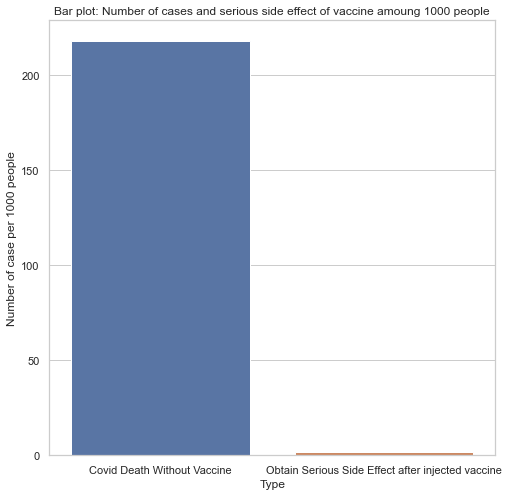

In [84]:
plt.figure(figsize=(8,8))
plot = sns.barplot(data=bar,x='Type',y='Number of case per 1000 people')
plt.title('Bar plot: Number of cases and serious side effect of vaccine amoung 1000 people')#,fontdict = {'fontsize' : 16})

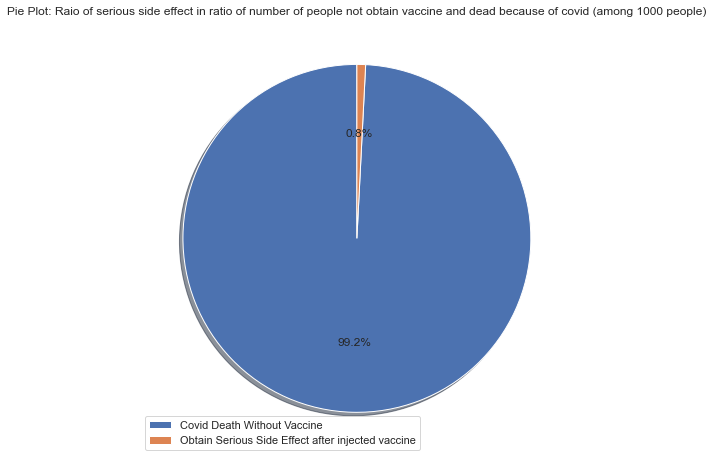

In [85]:
plt.figure(figsize=(8,8))
plt.pie(x=bar['Number of case per 1000 people'], labels= ['',''], autopct='%1.1f%%',shadow=True, startangle=90,)
plt.title('Pie Plot: Raio of serious side effect in ratio of number of people not obtain vaccine and dead because of covid (among 1000 people)')#,fontdict = {'fontsize' : 16})
plt.legend(loc=3, labels=bar['Type'])